In [1]:
pwd

'/data2/mito_lineage/Analysis/multiplex/test_vireo'

In [2]:
AD_F = "cellSNP.tag.AD.mtx"
DP_F = "cellSNP.tag.DP.mtx"
VCF_F = "cellSNP.base.vcf"
INDIR='.'
OUTDIR='./results/'
NUM_DONORS=4
prob_threshold=0.8
indirs = ("data/PBMC_J_cellSNP", "data/PBMC_P_cellSNP")




In [3]:
import os
import pandas as pd
import seaborn as sns
from glob import glob
from scipy import stats
from os.path import join
import numpy as np

# Examples of using vireoSNP for donor deconvolution

In [4]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread

## Load cellSNP data 

##### Option 1 - VCF format

In [5]:
# cell_vcf = vireoSNP.load_VCF(VCF_F, biallelic_only=True)
# cell_dat = vireoSNP.vcf.read_sparse_GeneINFO(cell_vcf['GenoINFO'], keys=['AD', 'DP'])

# AD = cell_dat['AD']
# DP = cell_dat['DP']

##### Option 2 - sparse matrices

In [6]:
# AD = mmread(AD_F).tocsc()
# DP = mmread(DP_F).tocsc()
# vcf = pd.read_csv(VCF_F, sep='\t')

AD = mmread("data/cellSNP_mat/cellSNP.tag.AD.mtx").tocsc()
DP = mmread("data/cellSNP_mat/cellSNP.tag.DP.mtx").tocsc()

vcf = pd.read_csv("data/cells.cellSNP.vcf.gz", sep="\t", skiprows=37)

/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
vcf.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,AAACCTGCACCCAGTG-1,...,TTTACTGCATCACGTA-3,TTTACTGCATCTGGTA-1,TTTACTGTCACTCTTA-2,TTTATGCAGAATGTGT-3,TTTATGCCATTGGGCC-4,TTTCCTCAGGCAGGTT-3D,TTTCCTCCACCGTTGG-3,TTTCCTCTCTTGAGGT-1,TTTGTCACAGTCGTGC-4,TTTGTCATCCATGCTC-1
0,1,1065797,.,G,C,.,PASS,AD=3;DP=12;OTH=0,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.
1,1,1217251,.,C,A,.,PASS,AD=2;DP=14;OTH=0,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.
2,1,1230695,.,G,A,.,PASS,AD=2;DP=13;OTH=0,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.
3,1,1722625,.,A,T,.,PASS,AD=8;DP=24;OTH=0,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,.:.:.:.:.:.,.:.:.:.:.:.,"1/1:45,3,0:1:1:0:0,0,0,1,0",.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.
4,1,1860718,.,A,C,.,PASS,AD=20;DP=36;OTH=0,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.


Note, `AD` and `DP` are sparse matrices, not `numpy.array`

## Run Vireo
For donor deconvolution, the `vireoSNP.vireo_wrap` function can be directly used, which contains multiple initialization and have options for different situtaions of donor genotype, fully missing, partially lack, or all available.

In [8]:
res = vireoSNP.vireo_wrap(AD, DP, n_donor=NUM_DONORS, learn_GT=True,
                          n_extra_donor=0, ASE_mode=False, fix_beta_sum=False,
                          n_init=50, check_doublet=True, random_seed=1)

[vireo] lower bound ranges [-29456.1, -25592.6, -19155.3]
[vireo] allelic rate mean and concentrations:
[[0.017 0.462 0.941]]
[[28199.7 38020.2 21634.1]]
[vireo] donor size before removing doublets:
donor0	donor1	donor2	donor3
241	246	234	231


In [9]:
res.keys()

dict_keys(['ID_prob', 'GT_prob', 'doublet_prob', 'theta_shapes', 'theta_mean', 'theta_sum', 'LB_list', 'LB_doublet'])

##### The donor assignment probability

In [10]:
res["ID_prob"].shape

(952, 4)

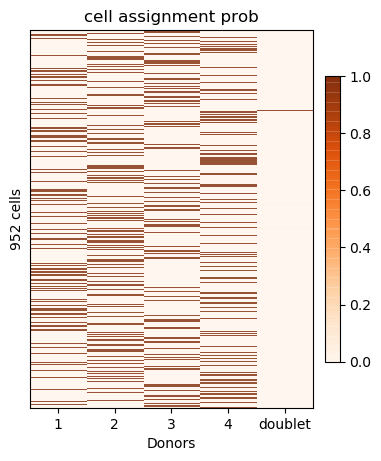

In [11]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(4, 5), dpi=100)
# assign_prob_comb = res['ID_prob']
assign_prob_comb = np.append(res['ID_prob'], 
                             np.sum(res['doublet_prob'], axis=1, 
                                    keepdims=True), axis=1)
im = heat_matrix(assign_prob_comb,
                 cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=False)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("cell assignment prob")
plt.xlabel("Donors")
plt.ylabel("%d cells" %(res['ID_prob'].shape[0]))
plt.yticks([])
plt.xticks(np.arange(NUM_DONORS+1), np.append(np.arange(NUM_DONORS)+1,"doublet"))

# plt.tight_layout()
plt.show()

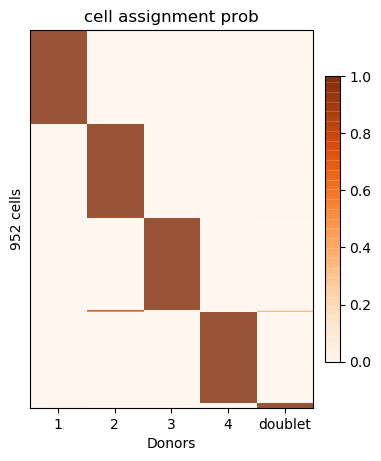

In [12]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(4, 5), dpi=100)
# assign_prob_comb = res['ID_prob']
assign_prob_comb = np.append(res['ID_prob'], 
                             np.sum(res['doublet_prob'], axis=1, 
                                    keepdims=True), axis=1)
im = heat_matrix(assign_prob_comb,
                 cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("cell assignment prob")
plt.xlabel("Donors")
plt.ylabel("%d cells" %(res['ID_prob'].shape[0]))
plt.yticks([])
plt.xticks(np.arange(NUM_DONORS+1), np.append(np.arange(NUM_DONORS)+1,"doublet"))

# plt.tight_layout()
plt.show()

In [13]:
res["ID_prob"].shape

(952, 4)

In [14]:
AD_dense = AD.todense()
(AD_dense > 0).sum(axis=1).shape

(3784, 1)

In [15]:
AD_dense = AD.todense()
(AD_dense > 0).sum(axis=0).shape

(1, 952)

In [16]:
AD_dense.shape

(3784, 952)

## Compare cell IDs to known values

In [17]:
## donor id with highest probability
donor_ids_best = np.argmax(res['ID_prob'], axis=1)

### Assignment probability threshold

In [18]:
## doublet rate

doublet_threshold = 0.9
is_doublet = np.sum(res['doublet_prob'], axis=1) > doublet_threshold
print("%d cells are called doublet" %(sum(is_doublet)))

prob_threshold = prob_threshold #0.9
is_unassigned = (np.max(res['ID_prob'], axis=1) < prob_threshold) & (~is_doublet)
print("%d cells are unassigned to singlet or doublets" %(sum(is_unassigned)))

13 cells are called doublet
3 cells are unassigned to singlet or doublets


### Allelic ratio per variant per donor

In [19]:
## If ASE_mode is False
AF_SNPs = np.tensordot(res['GT_prob'], res['theta_mean'][0, :], axes=[2, 0])

## Get the top averaged SNP AF , print out the AD counts in each sample and get the vcf

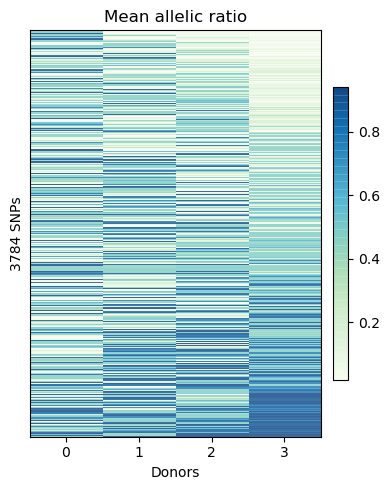

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(4, 5), dpi=100)
im = heat_matrix(AF_SNPs, cmap="GnBu", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Donors")
plt.ylabel("%d SNPs" %(AF_SNPs.shape[0]))
plt.yticks([])
plt.xticks(np.arange(AF_SNPs.shape[1]))

plt.tight_layout()
#plt.show()

In [21]:
for ind in range(NUM_DONORS):
    vcf["AF " + str(ind)] = AF_SNPs[:, ind]
#vcf.iloc[ind.argsort()[::-1]].head(100)
vcf.iloc[vcf["AF " + str(ind)].argsort()[::-1].values]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,AAACCTGCACCCAGTG-1,...,TTTATGCCATTGGGCC-4,TTTCCTCAGGCAGGTT-3D,TTTCCTCCACCGTTGG-3,TTTCCTCTCTTGAGGT-1,TTTGTCACAGTCGTGC-4,TTTGTCATCCATGCTC-1,AF 0,AF 1,AF 2,AF 3
1458,6,85678170,.,G,T,.,PASS,AD=2387;DP=2658;OTH=0,GT:PL:AD:DP:OTH:ALL,"1/1:77,6,0:2:2:0:0,0,0,2,0",...,"1/1:224,15,0:5:5:0:0,0,0,5,0","1/0:334,27,45:8:9:0:0,0,1,8,0","1/1:45,3,0:1:1:0:0,0,0,1,0",.:.:.:.:.:.,"1/1:376,27,0:9:9:0:0,0,0,9,0",.:.:.:.:.:.,0.940947,0.599607,0.940947,0.940947
3413,19,35169605,.,G,A,.,PASS,AD=153;DP=173;OTH=2,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,0.940947,0.940947,0.461999,0.940947
1309,6,31355111,.,A,G,.,PASS,AD=191;DP=258;OTH=0,GT:PL:AD:DP:OTH:ALL,"1/1:45,3,0:1:1:0:0,0,1,0,0",...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,0.940947,0.940807,0.461999,0.940947
1283,6,29945265,.,C,T,.,PASS,AD=417;DP=515;OTH=0,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,"1/1:90,6,0:2:2:0:0,0,0,2,0","1/1:42,3,0:1:1:0:0,0,0,1,0",0.940947,0.940947,0.461999,0.940947
2804,16,1964282,.,A,G,.,PASS,AD=128;DP=382;OTH=3,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,"1/1:42,3,0:1:1:0:0,0,1,0,0","0/0:0,3,45:0:1:0:1,0,0,0,0",.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,0.444960,0.463564,0.461999,0.940947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,11,8685686,.,C,T,.,PASS,AD=1595;DP=6513;OTH=6,GT:PL:AD:DP:OTH:ALL,"1/0:367,45,269:9:15:0:0,6,0,9,0",...,"0/0:0,3,45:0:1:0:0,1,0,0,0","1/0:582,87,713:13:29:0:0,16,0,13,0",.:.:.:.:.:.,"0/0:0,6,72:0:2:0:0,2,0,0,0","0/0:0,3,45:0:1:0:0,1,0,0,0","1/0:87,18,179:2:6:0:0,4,0,2,0",0.461999,0.017134,0.461999,0.017134
1291,6,31269347,.,T,C,.,PASS,AD=176;DP=375;OTH=2,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,"0/0:0,3,45:0:1:0:0,0,0,1,0","1/1:82,6,0:2:2:0:0,2,0,0,0",.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,0.462552,0.034746,0.461999,0.017134
2621,14,92121658,.,T,G,.,PASS,AD=45;DP=293;OTH=3,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,"0/0:0,3,42:0:1:0:0,0,0,1,0","0/0:0,3,45:0:1:0:0,0,0,1,0",.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,0.017134,0.017134,0.461999,0.017134
1306,6,31354526,.,C,G,.,PASS,AD=58;DP=370;OTH=2,GT:PL:AD:DP:OTH:ALL,"0/0:0,3,45:0:1:0:0,1,0,0,0",...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,0.017134,0.017140,0.461999,0.017134


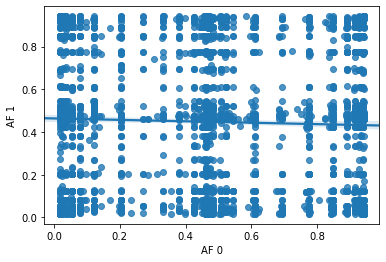

In [22]:
sns.regplot(data=vcf, x ="AF 0" , y="AF 1")

<Figure size 3000x3000 with 0 Axes>

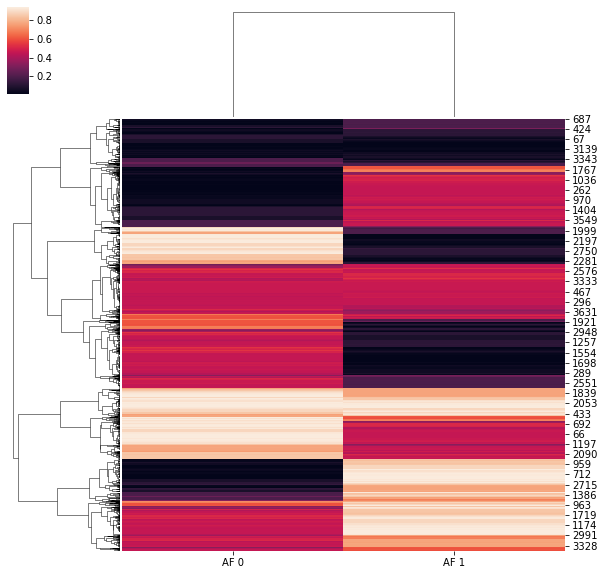

In [23]:
f = plt.figure(figsize=(10,10), dpi=300)
sns.clustermap(data=vcf[["AF 0" , "AF 1"]])

In [24]:
dense_ad = pd.DataFrame(AD.todense())
(dense_ad>0).sum().sum()

dense_dp = pd.DataFrame(DP.todense())
(dense_dp>0).sum().sum()

72858

In [25]:
print(f"Number of variants with 99.5% AF: {len(AF_SNPs[(np.absolute(AF_SNPs[:,0]-0.99518961))<0.01])}")

Number of variants with 99.5% AF: 0


In [26]:
vcf[(vcf["AF 0"]>0.9) & (vcf["AF 1"]>0.9)]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,AAACCTGCACCCAGTG-1,...,TTTATGCCATTGGGCC-4,TTTCCTCAGGCAGGTT-3D,TTTCCTCCACCGTTGG-3,TTTCCTCTCTTGAGGT-1,TTTGTCACAGTCGTGC-4,TTTGTCATCCATGCTC-1,AF 0,AF 1,AF 2,AF 3
44,1,16905456,.,A,G,.,PASS,AD=10;DP=12;OTH=0,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,0.914642,0.934330,0.121968,0.473360
106,1,36230311,.,T,C,.,PASS,AD=15;DP=17;OTH=0,GT:PL:AD:DP:OTH:ALL,"1/1:45,3,0:1:1:0:0,1,0,0,0",...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,0.937673,0.913986,0.521576,0.521577
119,1,42280215,.,C,T,.,PASS,AD=19;DP=26;OTH=0,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,0.940901,0.934324,0.053791,0.079975
120,1,42299691,.,G,A,.,PASS,AD=10;DP=15;OTH=0,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,"0/0:0,3,42:0:1:0:0,0,1,0,0",.:.:.:.:.:.,0.927660,0.927660,0.473360,0.037971
164,1,89907508,.,G,A,.,PASS,AD=9;DP=13;OTH=0,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,0.927660,0.914642,0.203158,0.079975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3573,20,49252325,.,A,T,.,PASS,AD=26;DP=29;OTH=0,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,0.940946,0.934327,0.079975,0.847690
3590,20,62150870,.,G,T,.,PASS,AD=26;DP=29;OTH=0,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,0.940555,0.940742,0.121998,0.927657
3591,20,63521958,.,G,C,.,PASS,AD=18;DP=21;OTH=0,GT:PL:AD:DP:OTH:ALL,"1/1:32,3,0:1:1:0:0,1,0,0,0",...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,0.910635,0.927660,0.847489,0.473360
3699,22,40233134,.,T,C,.,PASS,AD=10;DP=12;OTH=0,GT:PL:AD:DP:OTH:ALL,.:.:.:.:.:.,...,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,.:.:.:.:.:.,0.927660,0.914642,0.473360,0.424317


In [27]:
vcf[(vcf["AF 0"]>0.95) & (vcf["AF 2"]>0.95)]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,AAACCTGCACCCAGTG-1,...,TTTATGCCATTGGGCC-4,TTTCCTCAGGCAGGTT-3D,TTTCCTCCACCGTTGG-3,TTTCCTCTCTTGAGGT-1,TTTGTCACAGTCGTGC-4,TTTGTCATCCATGCTC-1,AF 0,AF 1,AF 2,AF 3


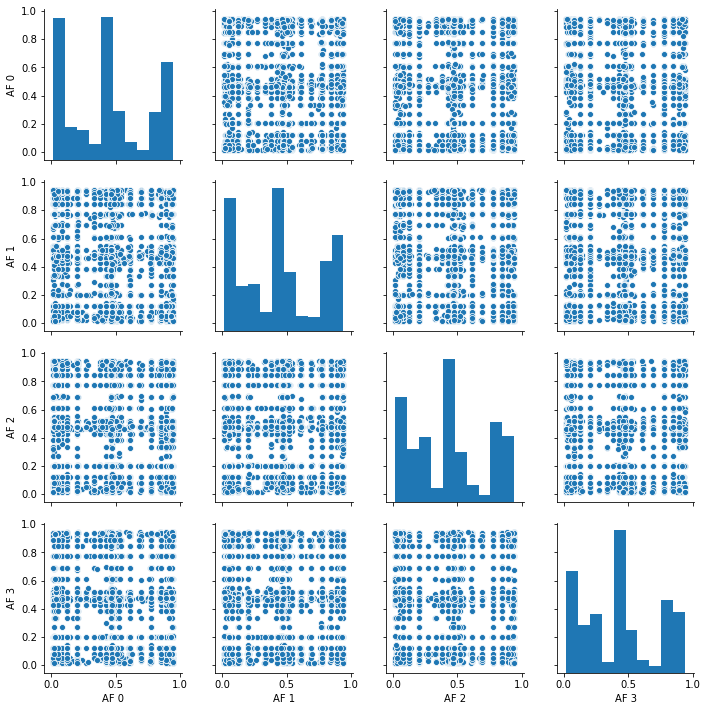

In [28]:
sns.pairplot(data=vcf, vars=["AF 0", "AF 1", "AF 2", "AF 3"])

In [29]:
ad_dense = AD.todense()
print(ad_dense.shape)
ad_dense

(3784, 952)


matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [30]:
dp_dense = DP.todense()
print(dp_dense.shape)
dp_dense

(3784, 952)


matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [31]:
np.array((dp_dense>0).sum(axis=0).flatten()).flatten().shape

(952,)

In [32]:
max(np.array((dp_dense>0).sum(axis=0).flatten()).flatten())

402

In [33]:
max(np.array((dp_dense>0).sum(axis=1).flatten()).flatten())

788

In [34]:
(np.array(dp_dense)==0).all(axis=0).sum()

0

In [35]:
(np.array(ad_dense)==0).all(axis=0).sum()

0

In [36]:
(np.array(ad_dense)==0).all(axis=1).sum()

3

In [37]:
(np.array(dp_dense)==0).all(axis=1).sum()

0

## Choose the number of donors

Unsually, the number of donors are known. In case you are not sure on this, you could try a set of numbers, e.g., from 2 to 6 here, and pick the one when the evidence lower bound (ELBO) stops increasing, e.g., 
[Figure 2A in Vireo paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1865-2/figures/2)

In this data set, `n_donor=4` is a sensible choice.

In [33]:
n_donor_list = np.arange(2, 7)
ELBO_list_all = []
for _n_don in n_donor_list:
    res = vireoSNP.vireo_wrap(AD, DP, n_donor=_n_don, learn_GT=True,
                              n_extra_donor=0, ASE_mode=False, fix_beta_sum=False,
                              n_init=50, check_doublet=True, random_seed=1)
    ELBO_list_all.append(res['LB_list'])

[vireo] lower bound ranges [-42583.3, -34775.1, -33917.3]
[vireo] allelic rate mean and concentrations:
[[0.064 0.437 0.849]]
[[24679.1 40819.5 22355.4]]
[vireo] donor size before removing doublets:
donor0	donor1
483	469
[vireo] lower bound ranges [-33921.1, -27814.6, -25535.5]
[vireo] allelic rate mean and concentrations:
[[0.026 0.445 0.91 ]]
[[25407.2 40997.2 21449.6]]
[vireo] donor size before removing doublets:
donor0	donor1	donor2
241	242	469
[vireo] lower bound ranges [-29456.1, -25592.6, -19155.3]
[vireo] allelic rate mean and concentrations:
[[0.017 0.462 0.941]]
[[28199.7 38020.2 21634.1]]
[vireo] donor size before removing doublets:
donor0	donor1	donor2	donor3
241	246	234	231
[vireo] lower bound ranges [-29997.3, -24381.9, -18709.2]
[vireo] allelic rate mean and concentrations:
[[0.019 0.457 0.929]]
[[28304.3 37007.5 22542.2]]
[vireo] donor size before removing doublets:
donor0	donor1	donor2	donor3	donor4
51	233	223	236	209
[vireo] lower bound ranges [-28605.3, -23995.5, -19

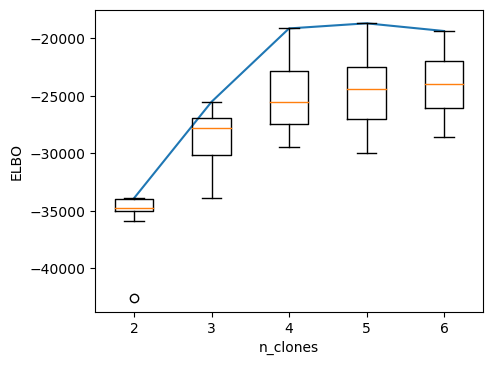

FileNotFoundError: [Errno 2] No such file or directory: './results/number_of_donors_ELBO.png'

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(5, 4), dpi=100)
plt.plot(n_donor_list - 1, np.max(ELBO_list_all, axis=1))
plt.boxplot(ELBO_list_all)
plt.xticks(n_donor_list - 1, n_donor_list)
plt.ylabel("ELBO")
plt.xlabel("n_clones")
plt.show()

plt.savefig(join(OUTDIR, "number_of_donors_ELBO.png"))